[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/stan/jet/notebooks/Normal_Crossing_SGLD_trajectory_notebook.ipynb)

# Normal Crossing SGLD trajectory notebook

This notebook uses SGLD to sample from the posterior around a point, for a polynomial model characterized by $y_{pred} = w_1^a * w_2^b * x$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned and $x$ is our (1-dimensional) input.

Both the input $x$ and target data $y$ are generated using (independent) gaussian noise, and the loss is Mean Squared Error from $y$ to $y_{pred}$, so the model achieves its lowest loss when $w_1=0$ or $w_2=0$.


#Setup (skippable)

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/timaeus-research/devinterp.git@stan/jet
else:
    %pip uninstall devinterp -y
    %cd ..
    %pip install -e .

%pip install ipywidgets ipympl
%matplotlib widget
%load_ext autoreload
%autoreload 2

from google.colab import output
output.enable_custom_widget_manager()

  Cloning https://github.com/timaeus-research/devinterp.git (to revision stan/jet) to /tmp/pip-req-build-244p8kc9
  Running command git clone --filter=blob:none --quiet https://github.com/timaeus-research/devinterp.git /tmp/pip-req-build-244p8kc9
  Running command git checkout -b stan/jet --track origin/stan/jet
  Switched to a new branch 'stan/jet'
  Branch 'stan/jet' set up to track remote branch 'stan/jet' from 'origin'.
  Resolved https://github.com/timaeus-research/devinterp.git to commit d6d5a6b354cdbad244836abc8a718133edb73b0f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 3.4 MB/s eta 0:00:00
  Created wheel for devinterp: filename=devinterp-1.2.0-py3-none-any.whl size=59706 sha256=182527329cd3af2a0b8cb7528187e3afb87cfea6659c875f41f17603fcf83bcc
  Stored in directory: /tmp/pip-ephem-wheel-cache-oiuqatnj/wheels/a5/38/f3/3eb48f64c88f89e8

In [3]:
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.llc import OnlineLLCEstimator
from devinterp.slt.sampler import sample
from devinterp.utils import default_nbeta, evaluate
from functools import partial

from devinterp.jet_tools.plot import *
from devinterp.jet_tools.models import *
from devinterp.jet_tools.diffs import *
from devinterp.jet_tools.utils import *

evaluate_mae = partial(evaluate, F.l1_loss)

# **Auxiliary functions**

In [4]:
# plotting
sns.set_style("whitegrid")

# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4))


lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple(
    [x + (1 - x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.0]
)

colors = [SECONDARY, lighter_SECONDARY]
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
SEED = 0
SIGMA = 1
NUM_TRAIN_SAMPLES = 100
BATCH_SIZE = NUM_TRAIN_SAMPLES
EVALUATE = evaluate_mae

train_loader, train_data, x, y = generate_dataset_for_seed(
    seed=SEED, sigma=SIGMA, batch_size=BATCH_SIZE, num_samples=NUM_TRAIN_SAMPLES
)

# **Model definition**

In [7]:
INITIAL_PARAMETERS = [0.0, 0.0]
# MSE loss function and zero-mean gaussian, so this is effectively w_1**2A * w_2**2B as loss, NB
A_B = [2, 3]

nbeta = default_nbeta(len(train_data))  # = n/log(n)
model = PolyModel(torch.tensor(A_B).to(DEVICE), DEVICE).to(DEVICE)
# model = PolyModelNoData(torch.tensor(A_B).to(DEVICE), DEVICE).to(DEVICE)
# model = SumModel(torch.tensor(A_B).to(DEVICE), DEVICE).to(DEVICE)
# model = SumModelNoData(torch.tensor(A_B).to(DEVICE), DEVICE).to(DEVICE)
model.weights = nn.Parameter(
    torch.tensor(INITIAL_PARAMETERS, dtype=torch.float32, requires_grad=True).to(DEVICE)
)

# **SGLD trajectories sampling**


In [8]:
sampling_method = SGLD
# Number and length of chains
num_chains_sgld = 1
num_draws_sgld = 10_000

# SGLD parameters
epsilon_sgld = 0.005

In [9]:
torch.manual_seed(SEED)
np.random.seed(SEED)
weights = WeightCallback(
    num_chains=num_chains_sgld, num_draws=num_draws_sgld, model=model
)
gradients = GradientCallback(
    num_chains=num_chains_sgld, num_draws=num_draws_sgld, model=model
)
online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgld,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)

trace_sgld = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(lr=epsilon_sgld, nbeta=nbeta,bounding_box_size=500.0),
    sampling_method=sampling_method,
    num_chains=num_chains_sgld,  # independent sampling runs
    num_draws=num_draws_sgld,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, weights, gradients],
    seed=SEED,
)

/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0: 100%|██████████| 10000/10000 [00:26<00:00, 374.29it/s]
/usr/local/lib/python3.10/dist-packages/devinterp/slt/llc.py:149: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered inte

In [10]:
wt_sgld = np.array(weights.get_results()["ws/trace"])
gd_sgld = np.array(gradients.get_results()["grads/trace"])
flattened_wts_sgld = wt_sgld.reshape((num_chains_sgld, num_draws_sgld, -1))
flattened_gds_sgld = gd_sgld.reshape((num_chains_sgld, num_draws_sgld, -1))
# numpy running mean of llc_chain (does not work yet with multiple chains)
llc_chain = online_llc_estimator.get_results()["llc/trace"]
# llc_chain = np.cumsum(llc_chain) / np.arange(1, len(llc_chain[0]) + 1)
print(np.nonzero(np.isnan(wt_sgld)))
print(epsilon_sgld * num_draws_sgld)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
50.0


# **SGLD plots**

## **Plotting SGLD trajectories and jet coordinates**

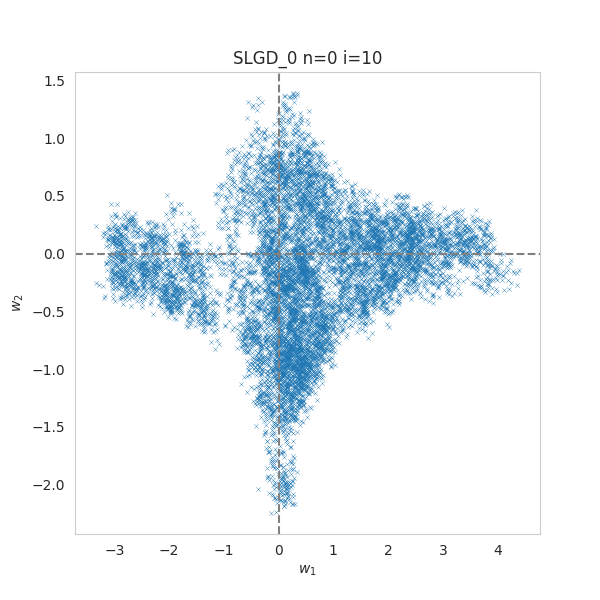

In [11]:
plot_multi_trajectories(wt_sgld, [10], [0], f"SLGD", model=model)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

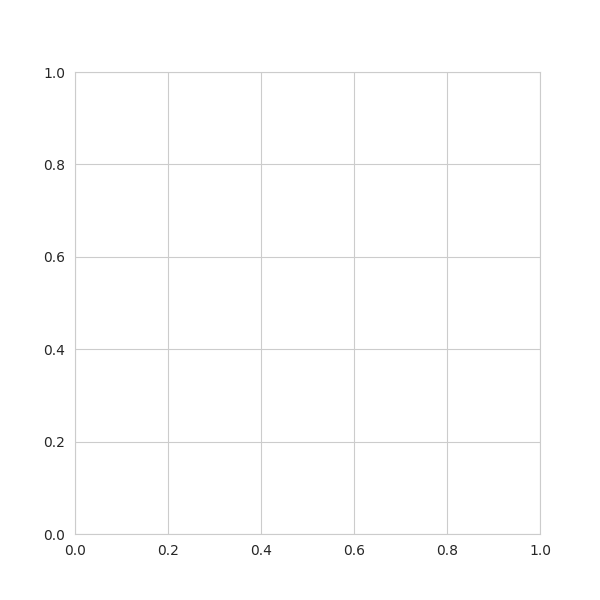

In [12]:
plot_multi_trajectories(wt_sgld, [80000], [1], f"SLGD", model=model)

## **Plot cumulant statistics of marginal distribution of jet coordinates SGLD**


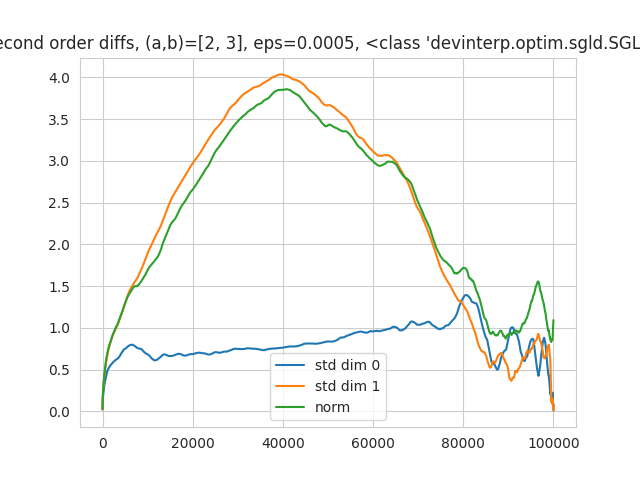

In [23]:
plot_second_order_one_place_stats(
    flattened_wts_sgld,
    1,
    title=f"Second order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

In [24]:
plot_third_order_stats_per_dim(
    flattened_wts_sgld,
    1,
    title=f"Third order diffs, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
    up_to_dim=2,
)

KeyboardInterrupt: 

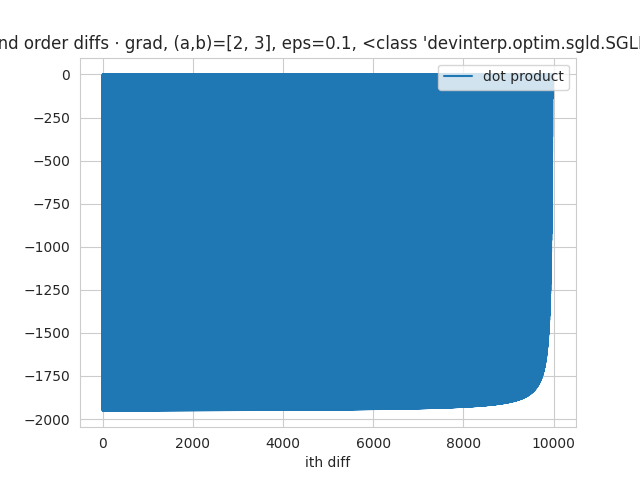

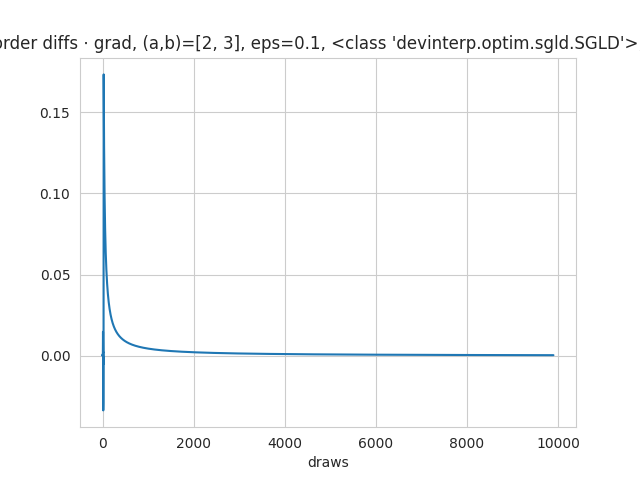

In [170]:
plot_second_order_one_place_dot_products(
    flattened_wts_sgld,
    flattened_gds_sgld,
    1,
    i_to_plot_draws_for=100,
    title=f"2nd order diffs ⋅ grad, (a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

## **Vector fields SGLD**

In [25]:
plot_combined_analysis(
    flattened_wts_sgld,
    flattened_gds_sgld,
    num_bins=15,
    title=f"(a,b)={A_B}, eps={epsilon_sgld}, {sampling_method}",
)

interactive(children=(IntSlider(value=100, continuous_update=False, description='i_to_plot_for:', max=2000, mi…

## Distances between empirical jet measures and "Boltzmann distribution":

In [13]:
## Various distances between probability distributions

# Maximum Mean Discrepancy distance

def rbf_kernel(x, y, gamma=1.0):
    # x, y are arrays of shape (N, d) and (M, d)
    # gamma > 0 is a kernel parameter
    diff = x[:, None, :] - y[None, :, :]
    return np.exp(-gamma * np.sum(diff**2, axis=2))

def mmd_distance(X, Y, gamma=1.0):
    Kxx = rbf_kernel(X, X, gamma)
    Kyy = rbf_kernel(Y, Y, gamma)
    Kxy = rbf_kernel(X, Y, gamma)

    n = len(X)
    m = len(Y)
    # Unbiased MMD^2
    mmd2 = (Kxx.sum() - np.trace(Kxx)) / (n*(n-1)) \
           + (Kyy.sum() - np.trace(Kyy)) / (m*(m-1)) \
           - 2 * Kxy.mean()
    return np.sqrt(mmd2)

# Energy distance

def energy_distance(X, Y):
    # X and Y are arrays of shape (N, d) and (M, d)
    # Compute pairwise distances
    dist_xx = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
    dist_yy = np.linalg.norm(Y[:, None, :] - Y[None, :, :], axis=2)
    dist_xy = np.linalg.norm(X[:, None, :] - Y[None, :, :], axis=2)

    return 2 * dist_xy.mean() - dist_xx.mean() - dist_yy.mean()

%pip install POT
from sklearn.metrics.pairwise import euclidean_distances
import ot  # Make sure you have POT installed: pip install POT

def wasserstein_distance(X, Y, p=1):
    """
    Compute the p-Wasserstein distance between two discrete distributions
    represented by point sets X and Y in R^d with uniform weights.

    Parameters
    ----------
    X : np.ndarray of shape (N, d)
        Points defining the first distribution (uniform weights).
    Y : np.ndarray of shape (M, d)
        Points defining the second distribution (uniform weights).
    p : float, optional (default=1)
        The order of the Wasserstein distance.

    Returns
    -------
    float
        The p-Wasserstein distance between the two distributions.
    """
    # Number of points in each distribution
    N, d = X.shape
    M, d_ = Y.shape
    assert d == d_, "Dimension mismatch between X and Y."

    # Uniform weight vectors
    a = np.ones(N) / N
    b = np.ones(M) / M

    # Compute pairwise Euclidean distances between points
    D = euclidean_distances(X, Y)
    # Raise these distances to the power p
    cost_matrix = D ** p

    # Solve the optimal transport problem
    P = ot.emd(a, b, cost_matrix)

    # The p-Wasserstein distance is (sum(P*C))^(1/p)
    Wp = np.sum(P * cost_matrix) ** (1.0 / p)
    return Wp

def sinkhorn_distance(X, Y, p=1, reg=0.01):
    """
    Compute the entropically regularized p-Wasserstein distance (Sinkhorn distance)
    between two discrete distributions represented by point sets X and Y in R^d
    with uniform weights.

    Parameters
    ----------
    X : np.ndarray of shape (N, d)
        Points defining the first distribution (uniform weights).
    Y : np.ndarray of shape (M, d)
        Points defining the second distribution (uniform weights).
    p : float, optional (default=1)
        The order of the Wasserstein distance.
    reg : float, optional (default=0.01)
        The entropic regularization parameter (epsilon).
        Smaller values are more accurate but slower.

    Returns
    -------
    float
        The entropically regularized p-Wasserstein (Sinkhorn) distance between the two distributions.
    """
    N, d = X.shape
    M, d_ = Y.shape
    assert d == d_, "Dimension mismatch between X and Y."
    assert np.all(np.isfinite(X)) and np.all(np.isfinite(Y)), "Data contains non-finite values."

    # Uniform weights
    a = np.ones(N) / N
    b = np.ones(M) / M

    # Pairwise distances
    D = euclidean_distances(X, Y)
    cost_matrix = D ** p
    cost_matrix += 1e-15

    # Compute the Sinkhorn transport plan
    P = ot.sinkhorn(a, b, cost_matrix, reg=reg,method='sinkhorn_log',numItermax=5000)

    # The Sinkhorn distance is (sum(P * C))^(1/p), similarly to the p-Wasserstein definition
    # Note: This is not the exact Wasserstein distance, but the regularized version.
    sink_dist = np.sum(P * cost_matrix) ** (1.0 / p)
    return sink_dist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 24.3 MB/s eta 0:00:00


In [38]:
# Parameters
i_range = [1,10,30,50,100,300,500]
i_range_len = len(i_range) +1 # +1 because we append the independent jet measure
wts = flattened_wts_sgnht
L = len(wts[0])
N= 5 # Use larger N to subsample


In [39]:
# Preparing the samples of 1-jets

rng = np.random.default_rng()
jets_1 = [ rng.choice(ith_place_first_diff(wts, i)[0],len(ith_place_first_diff(wts, i)[0])//N,replace=False) for i in i_range]
jets_joint_1 = [ rng.choice(joint_ith_place_nth_diff(wts, i)[0],len(joint_ith_place_nth_diff(wts, i)[0])//N,replace=False) for i in i_range]

# Independent differences of Boltzmann samples

X = rng.integers(L, size=L//N)
Y = rng.integers(L, size=L//N)

jets_1_indep = np.array([wts[0][Y[i]]-wts[0][X[i]] for i in range(L//N)])
jets_joint_1_indep = np.array([np.concatenate((wts[0][X[i]],wts[0][Y[i]]-wts[0][X[i]])) for i in range(L//N)])

jets_1.append(jets_1_indep)
jets_joint_1.append(jets_joint_1_indep)

# Filtering to remove clear outliers

def filter_by_norm(arr,max_norm):
  return arr[np.linalg.norm(arr,axis=1)<max_norm]

max_norm = 5

jets_joint_1 = [filter_by_norm(arr,max_norm) for arr in jets_joint_1]



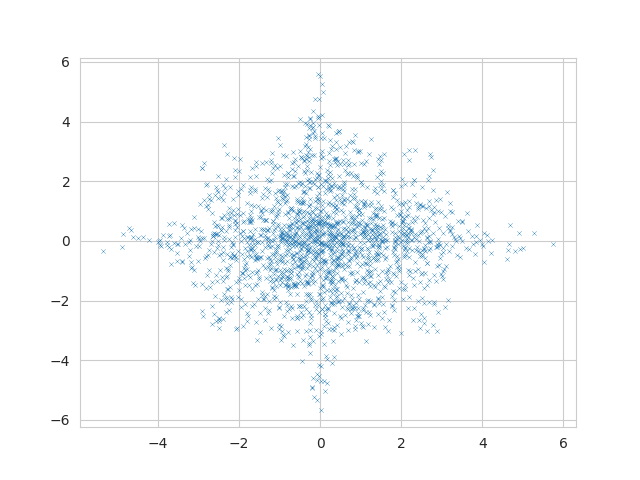

In [31]:
fig, ax1 = plt.subplots()
sns.scatterplot(x=jets_1_indep[:,0],y=jets_1_indep[:,1],s=10,marker="x")
plt.show()

<ipython-input-13-9918f826a158>:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mmd2)


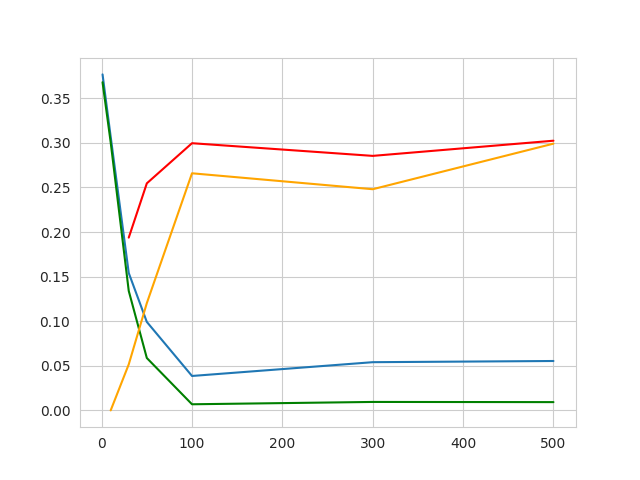

In [40]:
# Plotting MMD and energy distances of 1-jet measures to independent one


mmd_dist_to_indep=np.array([mmd_distance(jets_joint_1[i], jets_joint_1[i_range_len-1]) for i in range(i_range_len-1)])
mmd_dist_to_gaussian= np.array([mmd_distance(jets_joint_1[1], jets_joint_1[i+1]) for i in range(i_range_len-2)])
energy_dist_to_indep=np.array([energy_distance(jets_joint_1[i], jets_joint_1[i_range_len-1]) for i in range(i_range_len-1)])
energy_dist_to_gaussian= np.array([energy_distance(jets_joint_1[1], jets_joint_1[i+1]) for i in range(i_range_len-2)])

fig, ax1 = plt.subplots()
ax1.plot(i_range, mmd_dist_to_indep)
ax1.plot(i_range, energy_dist_to_indep,color="green")
ax1.plot(i_range[1:], mmd_dist_to_gaussian,color="red")
ax1.plot(i_range[1:], energy_dist_to_gaussian,color="orange")
plt.show()

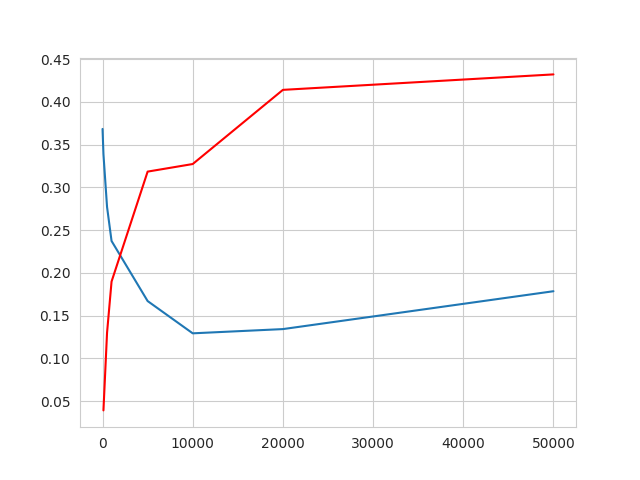

In [16]:
fig, ax1 = plt.subplots()
ax1.plot(i_range, mmd_dist_to_indep)
ax1.plot(i_range[1:], mmd_dist_to_gaussian,color="red")
plt.show()

In [ ]:
# Plotting Wasserstein distances of 1-jet measures to independent one (warning: more computationally expensive, may want to subsample or reduce i_range)

p=1
reg=0.05

wasserstein_dist_to_indep=np.array([sinkhorn_distance(jets_joint_1[i], jets_joint_1[i_range_len-1],p,reg) for i in range(i_range_len-1)])
wasserstein_dist_to_gaussian= np.array([sinkhorn_distance(jets_joint_1[1], jets_joint_1[i+1],p,reg) for i in range(i_range_len-2)])

fig, ax1 = plt.subplots()
ax1.plot(i_range, wasserstein_dist_to_indep)
ax1.plot(i_range[1:], wasserstein_dist_to_gaussian,color="green")
plt.show()

In [150]:
# MMD distance matrix for 1st jet coordinate

mmd_matrix = np.zeros((i_range_len,i_range_len))

for i in range(i_range_len):
  for j in range(i+1,i_range_len):
    mmd_matrix[i][j] = mmd_distance(jets_1[i], jets_1[j])

np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"},linewidth=400)
print(i_range)
print(mmd_matrix)

KeyboardInterrupt: 

In [118]:
# MMD distance matrix for joint distribution of 1st jets

mmd_joint_matrix = np.zeros((i_range_len,i_range_len))

for i in range(i_range_len):
  for j in range(i+1,i_range_len):
    mmd_joint_matrix[i][j] = mmd_distance(jets_joint_1[i], jets_joint_1[j])

np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"},linewidth=400)
print(i_range)
print(mmd_joint_matrix)

[1, 50, 100, 200, 500, 800, 1000, 5000, 10000, 15000, 20000, 30000, 40000]
[[         0     0.1967     0.2522     0.2828     0.3423     0.3415     0.3428     0.3511      0.364     0.3451      0.369       0.39      0.351     0.3671]
 [         0          0    0.06941      0.107     0.1729     0.1797     0.1788     0.1948      0.212     0.1813     0.2086     0.2444      0.201     0.2085]
 [         0          0          0    0.03339     0.1135     0.1291     0.1196      0.137     0.1628     0.1204     0.1554     0.1988     0.1536     0.1574]
 [         0          0          0          0    0.06361    0.09298     0.0829     0.1019     0.1324    0.09234     0.1041     0.1644     0.1345     0.1261]
 [         0          0          0          0          0        nan    0.03729    0.03827    0.06794    0.05513     0.0301     0.1066     0.1061    0.06225]
 [         0          0          0          0          0          0        nan    0.04469    0.02411        nan    0.06045    0.08622    0.0

<ipython-input-11-8a0b86010cc2>:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mmd2)


In [119]:
# Energy distance matrix

energy_matrix = np.zeros((i_range_len,i_range_len))

for i in range(i_range_len):
  for j in range(i+1,i_range_len):
    energy_matrix[i][j] = energy_distance(jets_1[i], jets_1[j])

print(i_range)
print(energy_matrix)

[1, 50, 100, 200, 500, 800, 1000, 5000, 10000, 15000, 20000, 30000, 40000]
[[         0     0.2719       0.37     0.5307     0.7301     0.7685     0.9589     0.9781       1.08     0.9276      1.049      1.093     0.7245      1.039]
 [         0          0    0.01787    0.08617     0.2015     0.2508     0.3876      0.392      0.476     0.3514     0.4629     0.5075     0.2314     0.4462]
 [         0          0          0     0.0408     0.1159     0.1635     0.2753     0.2771     0.3516     0.2457     0.3358     0.3786      0.172     0.3229]
 [         0          0          0          0    0.04202     0.0692     0.1607     0.1476      0.217     0.1211     0.2321     0.2477    0.09019     0.1946]
 [         0          0          0          0          0    0.02282    0.06753     0.0526      0.108    0.05053     0.1008     0.1205     0.1011    0.07956]
 [         0          0          0          0          0          0    0.03135    0.02781    0.06255    0.01887    0.08391    0.07578    0.0

In [120]:
# Energy distance matrix joint

energy_joint_matrix = np.zeros((i_range_len,i_range_len))

for i in range(i_range_len):
  for j in range(i+1,i_range_len):
    energy_joint_matrix[i][j] = energy_distance(jets_joint_1[i], jets_joint_1[j])

print(i_range)
print(energy_joint_matrix)

[1, 50, 100, 200, 500, 800, 1000, 5000, 10000, 15000, 20000, 30000, 40000]
[[         0    0.05137    0.09488     0.1362     0.2534     0.3047     0.2888     0.3239     0.4192     0.3404     0.3691     0.4821     0.4017     0.4367]
 [         0          0    0.02493    0.04184     0.1239     0.1651     0.1517     0.1765     0.2613     0.1946     0.2159     0.3099     0.2587     0.2684]
 [         0          0          0    0.02047    0.07541    0.09909    0.09038     0.1243      0.179     0.1209     0.1569     0.2236     0.1821     0.1909]
 [         0          0          0          0    0.04118    0.07003    0.05748    0.07385     0.1372    0.09312    0.09451     0.1852     0.1646     0.1373]
 [         0          0          0          0          0    0.02468    0.02663    0.02753    0.06901    0.05889    0.03988     0.1305     0.1494    0.07123]
 [         0          0          0          0          0          0    0.01655    0.04346    0.02897    0.02552    0.04528    0.08829     0.

In [126]:
# Entropy-regularized Wasserstein distance matrix. Warning: computationally intensive and unstable!

p=1
reg=0.1

wasserstein_matrix = np.zeros((i_range_len,i_range_len))

for i in range(i_range_len):
  for j in range(i+1,i_range_len):
    wasserstein_matrix[i][j] = sinkhorn_distance(jets_1[i], jets_1[j],p,reg)

print(i_range)
print(wasserstein_matrix)

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:903: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


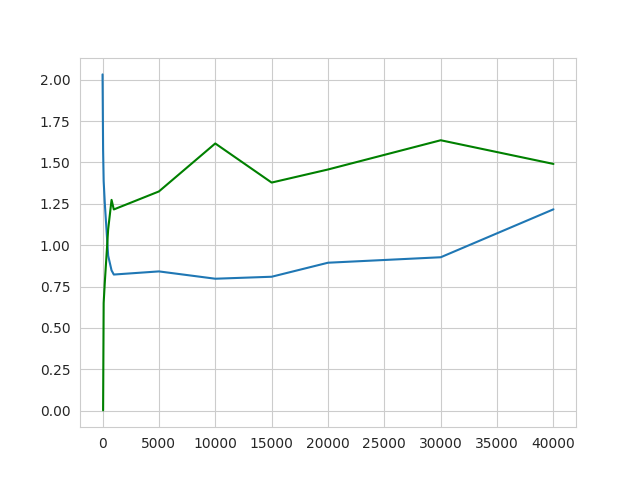

In [128]:
# Plotting Wasserstein

p=1
reg=0.05

wasserstein_dist_to_indep=np.array([sinkhorn_distance(jets_joint_1[i], jets_joint_1[i_range_len-1],p,reg) for i in range(i_range_len-1)])
wasserstein_dist_to_gaussian= np.array([sinkhorn_distance(jets_joint_1[1], jets_joint_1[i+1],p,reg) for i in range(i_range_len-2)])

fig, ax1 = plt.subplots()
ax1.plot(i_range, wasserstein_dist_to_indep)
ax1.plot(i_range[1:], wasserstein_dist_to_gaussian,color="green")
plt.show()

In [41]:
# Distances for joint distribution on 2-jets

n=2

# Preparing the samples of 2-jets

rng = np.random.default_rng()
jets_joint_2 = [ rng.choice(joint_ith_place_nth_diff(wts, i,n)[0],len(joint_ith_place_nth_diff(wts, i,n)[0])//N,replace=False) for i in i_range]

# Independent differences of Boltzmann samples

X = rng.integers(L, size=L//N)
Y = rng.integers(L, size=L//N)
Z = rng.integers(L, size=L//N)

jets_joint_2_indep = np.array([np.concatenate((wts[0][X[i]],wts[0][Y[i]]-wts[0][X[i]],wts[0][Z[i]]-2*wts[0][Y[i]]+wts[0][X[i]])) for i in range(L//N)])

jets_joint_2.append(jets_joint_2_indep)


<ipython-input-13-9918f826a158>:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mmd2)


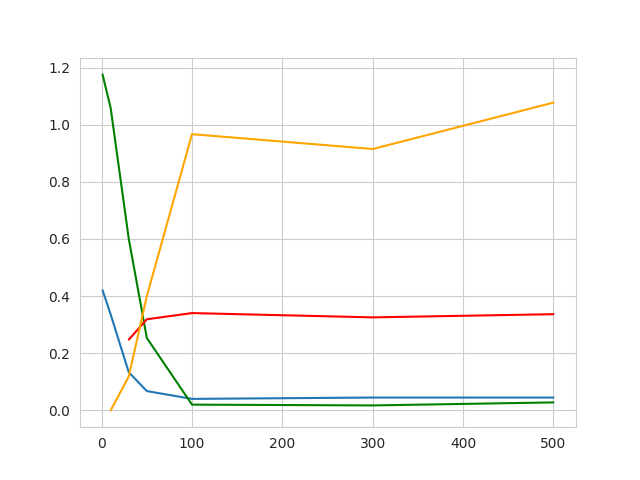

In [42]:
# Plotting MMD and energy distances of 2-jet measures to independent one

mmd_dist_to_indep=np.array([mmd_distance(jets_joint_2[i], jets_joint_2[i_range_len-1]) for i in range(i_range_len-1)])
mmd_dist_to_gaussian= np.array([mmd_distance(jets_joint_2[1], jets_joint_2[i+1]) for i in range(i_range_len-2)])
energy_dist_to_indep=np.array([energy_distance(jets_joint_2[i], jets_joint_2[i_range_len-1]) for i in range(i_range_len-1)])
energy_dist_to_gaussian= np.array([energy_distance(jets_joint_2[1], jets_joint_2[i+1]) for i in range(i_range_len-2)])

fig, ax1 = plt.subplots()
ax1.plot(i_range, mmd_dist_to_indep)
ax1.plot(i_range, energy_dist_to_indep,color="green")
ax1.plot(i_range[1:], mmd_dist_to_gaussian,color="red")
ax1.plot(i_range[1:], energy_dist_to_gaussian,color="orange")
plt.show()

# **SGHNT trajectories sampling**

In [25]:
num_chains_sgnht = 1
num_draws_sgnht = 10_000

epsilon_sgnht = 0.001

In [26]:
sgnht_weights = WeightCallback(
    num_chains=num_chains_sgnht, num_draws=num_draws_sgnht, model=model
)
online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgnht,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)
sgnht_gradients = GradientCallback(
    num_chains=num_chains_sgnht, num_draws=num_draws_sgnht, model=model
)
sampling_method = SGNHT
trace_sgnht = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(
        lr=epsilon_sgnht, nbeta=nbeta, diffusion_factor=0.005, bounding_box_size=3.0
    ),
    sampling_method=sampling_method,
    num_chains=num_chains_sgnht,  # independent sampling runs
    num_draws=num_draws_sgnht,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, sgnht_weights, sgnht_gradients],
    seed=SEED,
)

/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0: 100%|██████████| 10000/10000 [00:31<00:00, 316.23it/s]
/usr/local/lib/python3.10/dist-packages/devinterp/slt/llc.py:149: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered inte

In [28]:
wt_sgnht = np.array(sgnht_weights.get_results()["ws/trace"])
gd_sgnht = np.array(sgnht_gradients.get_results()["grads/trace"])
flattened_wts_sgnht = wt_sgnht.reshape((num_chains_sgnht, num_draws_sgnht, -1))
flattened_gds_sgnht = gd_sgnht.reshape((num_chains_sgnht, num_draws_sgnht, -1))
print(np.nonzero(np.isnan(wt_sgnht)))
print(epsilon_sgld * num_draws_sgnht)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
50.0


# **SGNHT plots**

## **Plotting SGNHT trajectories and jet coordinates**




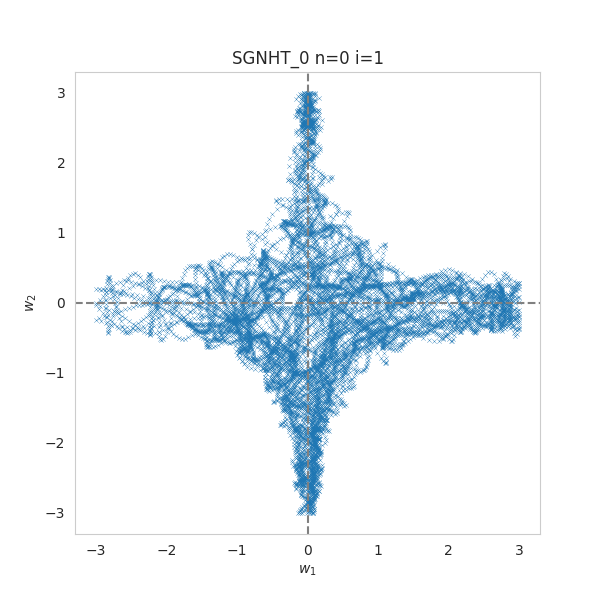

In [37]:
plot_multi_trajectories(wt_sgnht, [1], [0], "SGNHT", model=model)

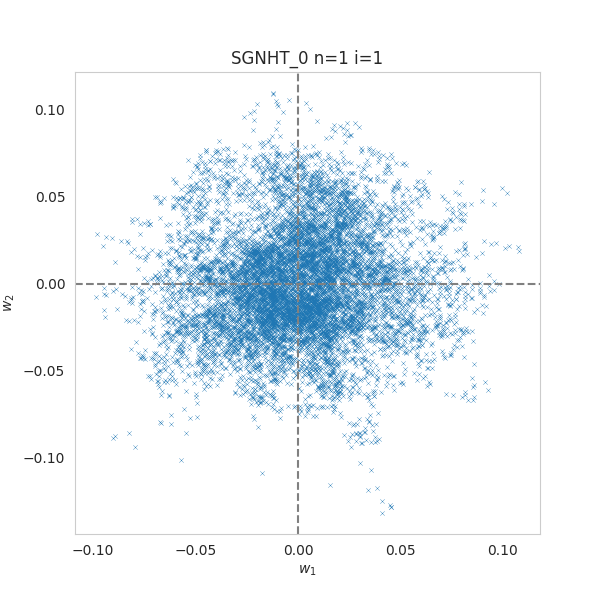

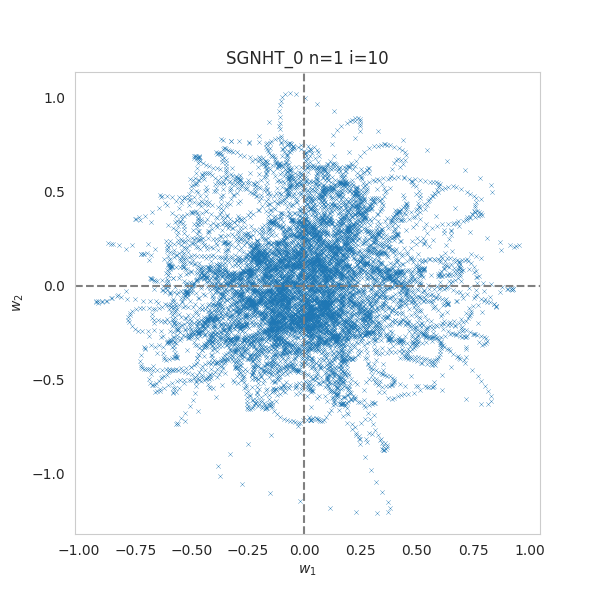

/usr/local/lib/python3.10/dist-packages/devinterp/jet_tools/plot.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(weight_trajectories), figsize=(6, 6))


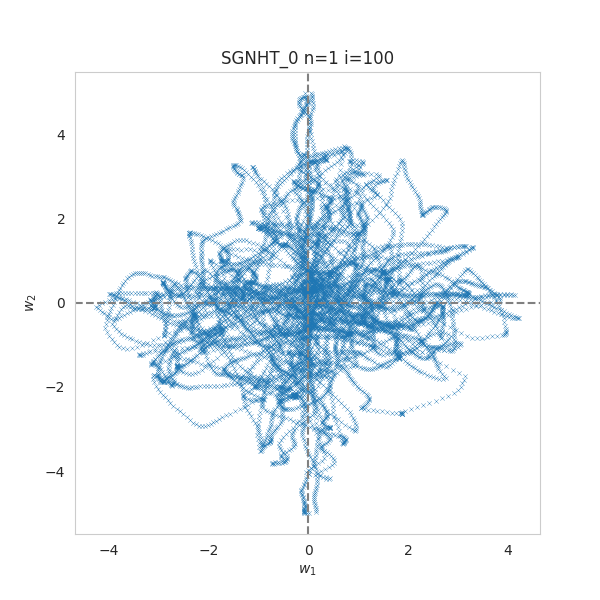

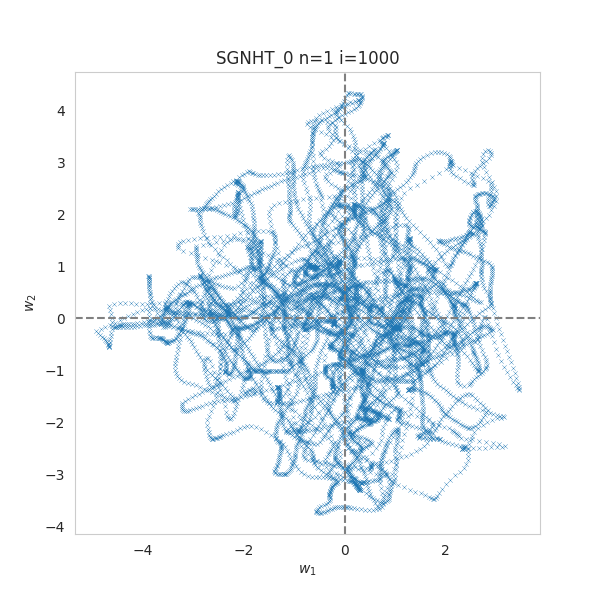

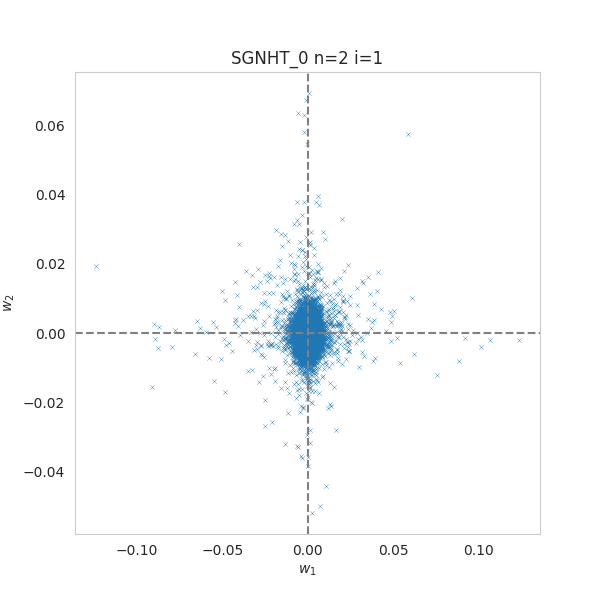

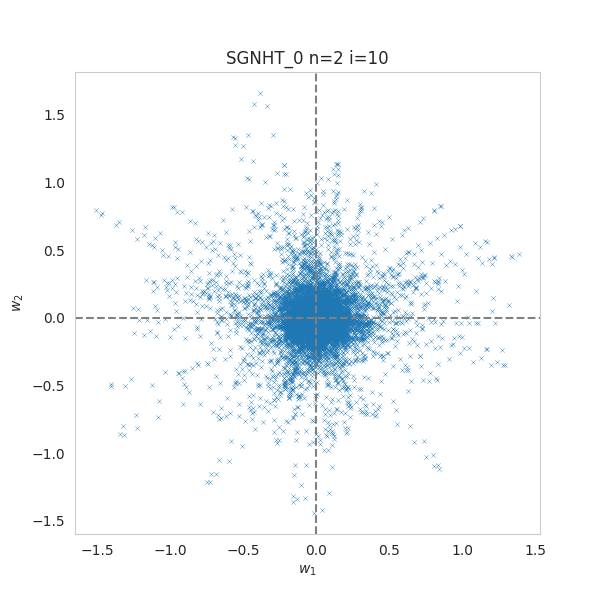

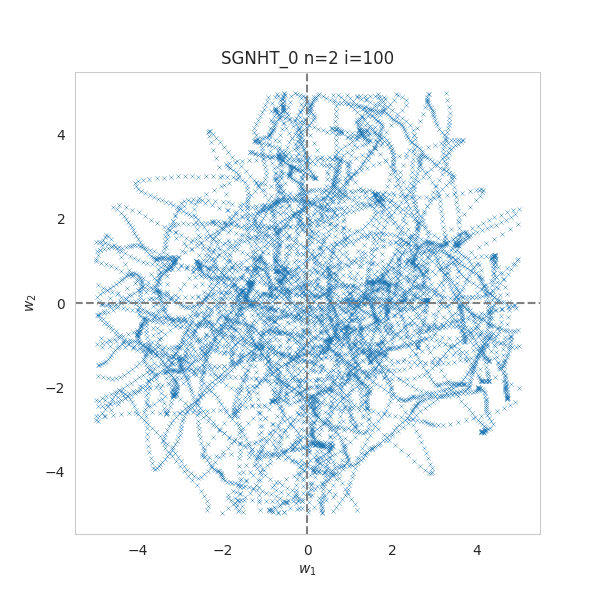

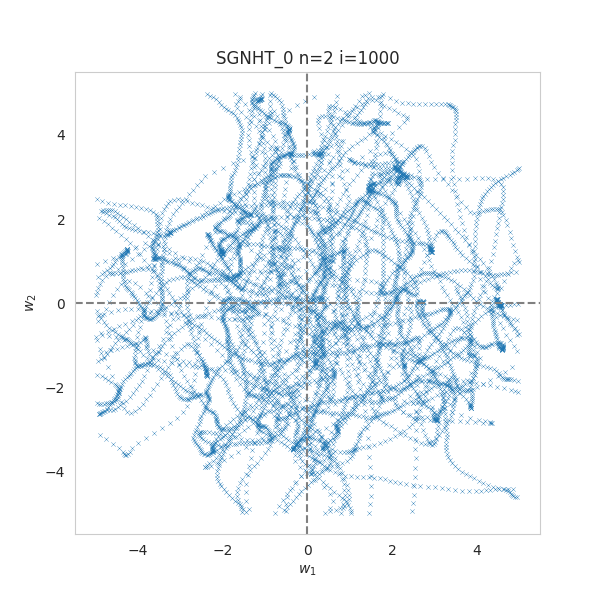

In [36]:
plot_multi_trajectories(wt_sgnht, [1, 10,100,1000], [1, 2], "SGNHT", model=model)

## **Plot cumulant statistics of marginal distribution of jet coordinates SGNHT**

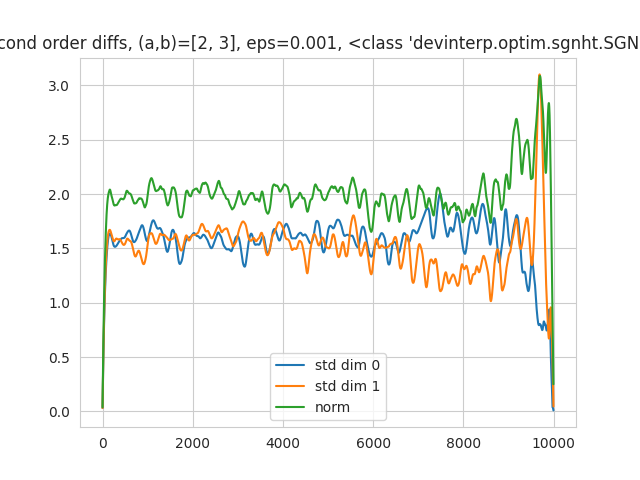

In [ ]:
flattened_wts_sgnht = wt_sgnht.reshape((num_chains_sgnht, num_draws_sgnht, -1))
flattened_gds_sgnht = gd_sgnht.reshape((num_chains_sgnht, num_draws_sgnht, -1))

plot_second_order_one_place_stats(
    flattened_wts_sgnht,
    1,
    title=f"Second order diffs, (a,b)={A_B}, eps={epsilon_sgnht}, {sampling_method}",
)

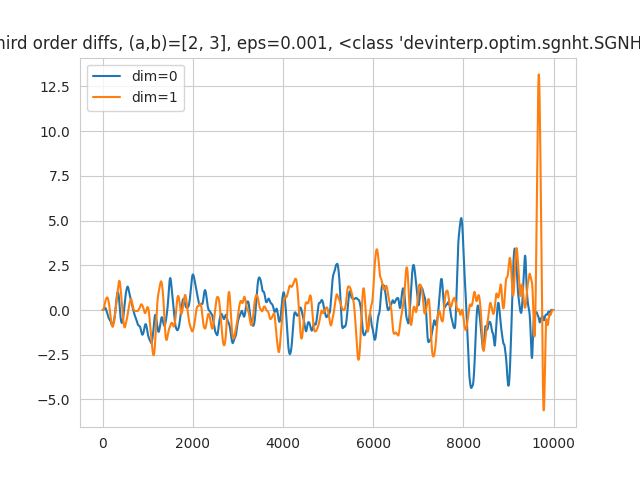

In [ ]:
plot_third_order_stats_per_dim(
    flattened_wts_sgnht,
    1,
    title=f"Third order diffs, (a,b)={A_B}, eps={epsilon_sgnht}, {sampling_method}",
    up_to_dim=2,
)

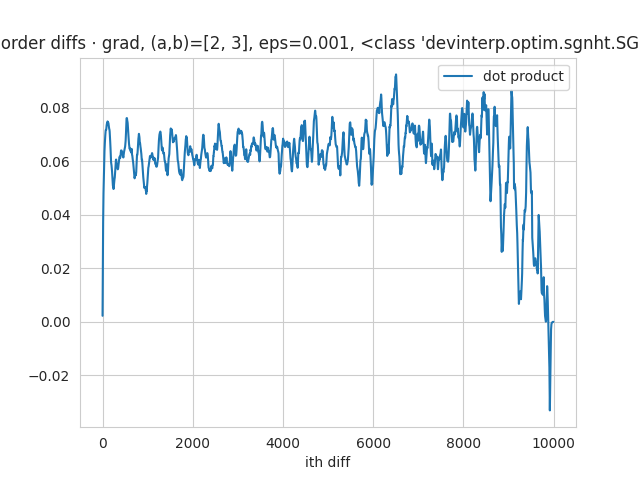

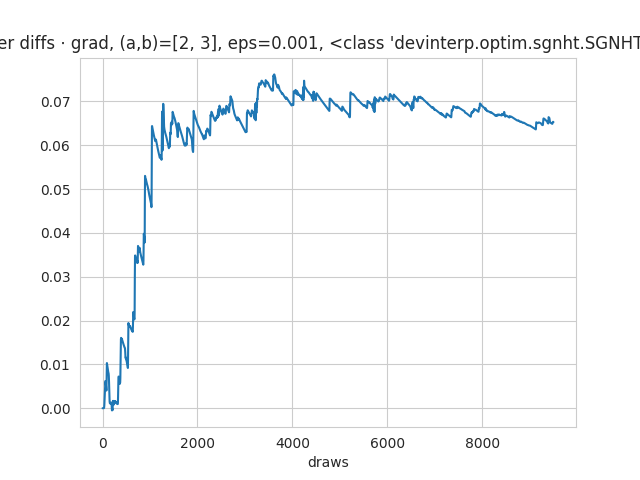

In [ ]:
plot_second_order_one_place_dot_products(
    flattened_wts_sgnht,
    flattened_gds_sgnht,
    1,
    i_to_plot_draws_for=500,
    title=f"2nd order diffs ⋅ grad, (a,b)={A_B}, eps={epsilon_sgnht}, {sampling_method}",
)

## **Vector fields SGNHT**

In [ ]:
plot_combined_analysis(
    flattened_wts_sgnht, flattened_gds_sgnht, num_bins=15, title="SGNHT"
)

interactive(children=(IntSlider(value=100, continuous_update=False, description='i_to_plot_for:', max=2000, mi…